Verify the imports
NOTE: Please do NOT edit this panel! 

# HidPy - Stage 1

## About
This is the first stage of the HidPy workflow. It loads the input video sequence, computes the optical flow maps, computes the trajectories, computes the MSD and applies Baysien inference to the MSD.

## 1.1 Import the system package

_Note: Please do NOT edit this panel._ 

In [1]:
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

## 1.2 Input Panel
The user must update the input parameters before running the pipeline. 

_Notes_
+ The __pixel threshold__ value is selected based on trial and error. After loading the sequence, compute the trajectories and verify if the computed trajectories are acceptable to run the MSD step or not. 
+ The __pixel size__ and __dt__ values are obtained from the meta-data associated with the imaging sequence. 
+ The current implementation supports loading video sequences in __.avi__ and __.mp4__ formats. If you have any __.tiff__ sequences, use Fiji to convert them. 
+ The analysis results will be generated to the __root output directory__.  

In [6]:
# Input video sequence (single sequence)   
video_sequence = '%s/../data/protocol/1-1/1-1.tiff' % os.getcwd()

# Pixel threshold, this value should be tested with trial-and-error
pixel_threshold = 90

# Pixel size (should be in microns, and should be known from the microscope camera)
pixel_size = 0.088

# Time step (should be in seconds)
dt = 0.200  

# The models. Users must either select all or some of them  
models_selected = ['D','DA','V','DV','DAV'] 

# Output directory 
root_output_directory = '%s/../output-protocol/' % os.getcwd()

# Get the prefix, typically with the name of the video sequence  
prefix = '%s_pixel-%2.2f_dt-%2.2f_threshold_%s' % (pathlib.Path(video_sequence).stem, pixel_size, dt, pixel_threshold)

## 1.3 Load Video Sequence
In this stage, we verify that the given data by the user is correct and load the view sequnce to start the procedure. 

_Note: Please do NOT edit this panel._ 

In [7]:
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
frames = video_processing.get_frame_list_from_sequence(
    sequence_path=video_sequence, verbose=True)

NOTE: The output path [/ssd1/projects/hidpy/notebooks/../output-protocol/] exists


100%|██████████████████████████████████████████████████| 151/151 [00:00<00:00, 876.15it/s]


	* Video Details: 
  	* Name: /ssd1/projects/hidpy/notebooks/../data/protocol/1-1/1-1.tiff 
  	* Number Frames 151


## 1.4 Plot Video Frames

In this stage, we display the first frame of the view sequence to use it as a reference for the optical flow maps and the trajectories computed later. 

_Note: Please do NOT edit this panel._ 

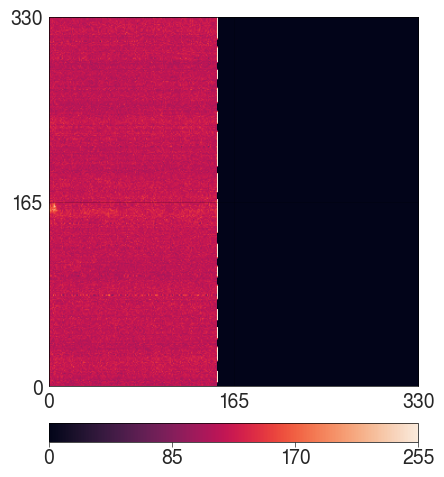

In [8]:
# Plot the first frames
plotting.verify_plotting_packages()
plotting.plot_frame(frame=frames[0], output_directory=output_directory, 
    frame_prefix=prefix, font_size=14, tick_count=3)

## 1.5 Compute Optical Flow

In this stage, we compute the optical flow fields using the OpenCV implementation of the Farenback algorithm.

_Note: Please do NOT edit this panel._ 

In [5]:
# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)

* Computing optical flow


100%|██████████████████████████████████████████████████| 150/150 [00:03<00:00, 44.34it/s]

Optical flow Time 3.385040


## 1.6 Interpolate Optical Flow Fields

In this stage, we interpolate the resulting optical flow field and generate floating-point maps. 

_Note: Please do NOT edit this panel._ 

In [ ]:
# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)

## 1.7 Create Trajectories

In this stage, we create the trajectories and plot them projected on the input image. 

_Note: This stage is significant to verify if the pixel threshold value used earlier was valid or not. If the result was noisy or sparse, please set a new value for the pixel threshold in stage 1.2._

_Note: Please do NOT edit this panel._ 

In [ ]:
# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
    
# Plot the trajectories 
print('* Plotting trajectories')
trajectory_image_prefix = '%s_trajectory' % prefix
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/%s' % (output_directory, trajectory_image_prefix))

## 1.8 Compute the Mean Square Displacement (MSD) Map and Fit the Models using Bayesian inference

_Note: This process use the parallel CPU cores using the joblib and multiprocessing library._

_Note: Please do NOT edit this panel._ 

In [ ]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement values to microns
xp_um = xp * pixel_size
yp_um = yp * pixel_size

# Extract nucleoli mask
print('* Extracting the nucleoli mask')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
msd_array = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Compute the inference, Baysian fit on MSDs 
print('* Fitting the MSDs models using Bayesian inference')
warnings.filterwarnings('ignore') # Ignore all the warnings 
bayes = inference.apply_bayesian_inference(msd_array, dt, models_selected)

## 1.9 Plot the maps of the Diffusion Constant, Anomalous Exponent and Drift Velocity 

_Note: Please do NOT edit this panel._ 

In [ ]:
import numpy as np
import core 

# The matrix that contains the mask of the nucli
# TODO: What is the hard-coded value of 100?
mask_matrix = np.zeros((frames[0].shape[0], frames[0].shape[1]))
mask_matrix[np.where(mask_nucleoli == 1) ] = 100

# Get the diffusion constant map (D)
diffusion_constant_matrix = bayes['D']
diffusion_constant_matrix[np.where(bayes['model'] == 0)] = np.nan
diffusion_constant_matrix[np.where(bayes['D'] < 1e-10)] = np.nan

# Get the anomalous exponent matrix (A)
anomalous_exponent_matrx = bayes['A']
anomalous_exponent_matrx[np.where(bayes['model'] == 0)] = np.nan
anomalous_exponent_matrx[np.where(bayes['A'] < 1e-10)] = np.nan

# Get the drift velocity matrix (V)
drift_velocity_matrix = bayes['V']
drift_velocity_matrix[np.where(bayes['model'] == 0)] = np.nan
drift_velocity_matrix[np.where(bayes['V']==0)] = np.nan

# Plot the model selection image 
model_selection_image_prefix = '%s_model_selection' % prefix
core.plotting.plot_model_selection_image(
    model_selection_matrix=bayes['model'], mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=model_selection_image_prefix, 
    font_size=14, title='Model Selection', tick_count=3)

# Plot the diffusion constant matrix
d_map_image_prefix = '%s_diffusion_constant_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=diffusion_constant_matrix, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=d_map_image_prefix, 
    font_size=14, title=r'Diffusion Constant ($\mu$m$^2$/s)', tick_count=3)

# Plot the anomalous matrix
a_map_image_prefix = '%s_anomalous_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=anomalous_exponent_matrx, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=a_map_image_prefix, 
    font_size=14, title='Anomalous Exponent', tick_count=3)

# Plot the drift velocity matrix
v_map_image_prefix = '%s_drift_velocity_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=drift_velocity_matrix, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=v_map_image_prefix, 
    font_size=14, title=r'Drift Velocity ($\mu$m/s)', tick_count=3)

## 1.10 Store the Intermediate Results 

_Note: Verify the path of the results and ensure that the input path to Stage 2.1 is the same._

_Note: Please do NOT edit this panel._ 

In [46]:
# Save pickle file per cell
import pickle

# Create the pickle directory 
pickle_directory = '%s/pickle' % output_directory
file_utils.create_directory(pickle_directory)

# Save the pickle file 
with open('%s/%s.pickle' % (pickle_directory, prefix), 'wb') as f:
    pickle.dump(bayes, f)

## 1.11 Create the HTML Report

Generate an HTML report summarizing and tabulating the analysis results of Stage 1.

In [47]:
# Generate report 
file_utils.create_report_1_summary(output_directory=output_directory,
                                   frame_0=prefix,
                                   trajectory=trajectory_image_prefix,
                                   model_selection=model_selection_image_prefix, 
                                   d_map=d_map_image_prefix, 
                                   a_map=a_map_image_prefix,
                                   v_map=v_map_image_prefix)